# Import Data

In [1]:
# helper.py
from helper import *

In [3]:
# load data
df = pd.read_csv('./data/clean/features.csv').drop(['Unnamed: 0'], axis=1)

# check
df.shape[0], len(set(df.player))

(1034, 227)

- Over 1000 QB seasons for training and validation.
- 223 features (excluding player name, team, year, and target).
- 227 unique QBs.

In [4]:
df.shape

(1034, 310)

In [8]:
# df to store model results
models_df = pd.read_csv('./models/models.csv').drop('Unnamed: 0', axis=1)
models_df.shape

(201, 6)

In [ ]:
def cross_val(estimator, df, poly=False, models_df=models_df, random_state=SEED):
    """    
    Scale features from the dataframe, incorporating Polynomial Features if specified.
    Perform 5-fold cross validation, append RMSE, R^2, and hyperparameters to models_df.
    
    Args:
    - estimator (sklearn.estimator) - estimator to cross validate
    - df (pandas.Dataframe) - dataframe to create X and y from
    - poly (boolean) - if True, transform features into polynomial
    
    Returns:
    - rmse (float) - average Root-Mean_Squared-Error from cross validation
    - r2 (float) - average R^2 from cross validation
    """

    # non-feature cols
    non_feature_cols = ['player', 'team_name', 'year', 'target']
    
    # features and target
    X = df.drop(non_feature_cols, axis=1)
    y = df.target

    # create pieline
    pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', estimator)])
        
    # polynomial features with degree = 2    
    if poly:
        pipeline = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)), ('estimator', estimator)])
    
    # 5-fold cross validation
    results = cross_validate(pipeline, X, y, cv=5, scoring=['neg_root_mean_squared_error', 'r2'])
    
    # get rmse and r-squared
    rmse = results['test_neg_root_mean_squared_error'].mean() * -1
    r2 = results['test_r2'].mean()
    
    # append results to models_df
    models_df.loc[len(models_df.index)] = [str(estimator), rmse, r2, poly]
    
    return rmse, r2

# Models
- Below, we create unique feature subsets and test them on 5 different machine learning algorithms.

In [7]:
# all features
all_feats = df.drop(['player', 'team_name', 'year', 'target'], axis=1).columns.tolist()

# normalized stats in the form of percentages or averages
percent_features = ['pass_accuracy_percent', 'pass_avg_depth_of_target', 'pass_avg_time_to_throw', 'pass_btt_rate', 
                    'pass_drop_rate', 'pass_grades_offense', 'pass_grades_pass', 'pass_pressure_to_sack_rate', 
                    'pass_sack_percent', 'pass_twp_rate', 'pass_ypa', 'rush_grades_run', 'rush_ypa', 'rush_yco_attempt', 
                    'pass_tds_gm', 'pass_yds_gm', 'exp', 'rolling_mean', 'rolling_std']

# features that have > 0.3 correlation with target, also including engineered features
high_corrs = ['player_game_count', 'pass_aimed_passes', 'pass_attempts', 'pass_bats', 'pass_big_time_throws', 
              'pass_completions', 'pass_def_gen_pressures', 'pass_dropbacks', 'pass_drops', 'pass_first_downs', 
              'pass_grades_offense', 'pass_grades_pass', 'pass_hit_as_threw', 'pass_interceptions', 'pass_passing_snaps', 
              'pass_penalties', 'pass_qb_rating', 'pass_sacks', 'pass_thrown_aways', 'pass_touchdowns', 
              'pass_turnover_worthy_plays', 'pass_yards', 'rush_attempts', 'rush_fumbles', 'rush_run_plays', 
              'rush_total_touches', 'rolling_mean', 'pass_tds_gm', 'pass_yds_gm', 'exp', 'rolling_std']

# 3 grades statistics + 4 engineered features
grades_only = ['pass_grades_offense', 'pass_grades_pass', 'rush_grades_run', 'pass_tds_gm', 'pass_yds_gm', 'exp', 
               'rolling_mean', 'rolling_std']

# offensive grade + 4 engineered features
grades_offense = ['pass_grades_offense', 'pass_tds_gm', 'pass_yds_gm', 'exp', 'rolling_mean', 'rolling_std']

# grades_only + total touchdown statistics
tds = grades_only + ['pass_tds_gm', 'pass_yds_gm']

# using domain knowledge to pick features i think will be most meaningful
intuition = ['pass_btt_rate', 'pass_twp_rate', 'pass_accuracy_percent', 'pass_pressure_to_sack_rate', 'rush_grades_run', 
                    'pass_tds_gm', 'pass_yds_gm', 'exp', 'rolling_mean', 'rolling_std']

In [8]:
# dict of name: feature subset
feature_subset_dict = {'all_feats': all_feats, 'percent_features': percent_features, 'high_corrs': high_corrs, 
                       'grades_only': grades_only, 'grades_offense': grades_offense, 'tds': tds, 'intuition': intuition}

### Linear Regression
- Good 'ol linear regression.

In [302]:
lr = LinearRegression()

In [303]:
# normal data
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(lr, df=df, feature_subset=feats, feature_subset_str=name)
    
# with pca
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(lr, df=df, feature_subset=feats, feature_subset_str=name, pca=True)
    
# with poly
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(lr, df=df, feature_subset=feats, feature_subset_str=name, poly=True)
    
# both pca and poly
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(lr, df=df, feature_subset=feats, feature_subset_str=name, pca=True, poly=True)

In [304]:
# 3 best LinReg
models_df[models_df['model'].str.contains('Linear')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
9,12.37,0.30,LinearRegression(),high_corrs,True,False
2,12.37,0.30,LinearRegression(),high_corrs,False,False
19,12.40,0.30,LinearRegression(),tds,False,True


- Best LinReg with a val RMSE of __12.37__. This is now our baseline to beat.

### KNN
- KNN is known to perform well with small data sets. 
- It is also known to thrive with smaller feature sets.

In [305]:
knn = KNeighborsRegressor()

In [306]:
# normal data
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(knn, df=df, feature_subset=feats, feature_subset_str=name)
    
# with pca
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(knn, df=df, feature_subset=feats, feature_subset_str=name, pca=True)
    
# with poly
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(knn, df=df, feature_subset=feats, feature_subset_str=name, poly=True)
    
# both pca and poly
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(knn, df=df, feature_subset=feats, feature_subset_str=name, pca=True, poly=True)

In [307]:
models_df[models_df['model'].str.contains('KN')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
37,13.02,0.23,KNeighborsRegressor(),high_corrs,True,False
30,13.10,0.22,KNeighborsRegressor(),high_corrs,False,False
51,13.18,0.21,KNeighborsRegressor(),high_corrs,True,True


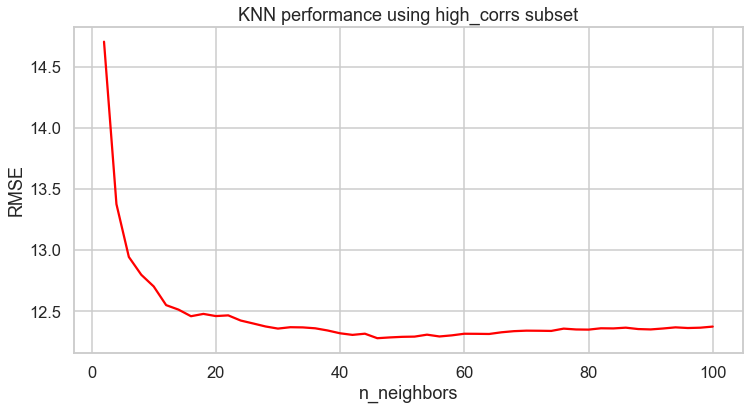

In [308]:
# 2-100 neighbors, increment by 2
k_values = range(2, 101, 2)

# to hold losses
losses = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # use best subset found from above
    rmse, r2 = cross_val(knn, df=df, feature_subset=high_corrs, feature_subset_str='high_corrs')
    
    # append losses
    losses.append(rmse) 
    
# plot results
plt.figure(figsize=(12, 6))
sns.lineplot(x=k_values, y=losses, color='red')

plt.title('KNN performance using high_corrs subset')
plt.ylabel('RMSE')
plt.xlabel('n_neighbors');

In [309]:
# 3 best KNN
models_df[models_df['model'].str.contains('KN')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
78,12.28,0.31,KNeighborsRegressor(n_neighbors=46),high_corrs,False,False
79,12.29,0.31,KNeighborsRegressor(n_neighbors=48),high_corrs,False,False
80,12.29,0.31,KNeighborsRegressor(n_neighbors=50),high_corrs,False,False


- Best KNN with a val RMSE of __12.28__. This is now our baseline to beat.

### Decision Tree
- Decision trees are good at handling many features. This means the "all_feats" set will likely perform well.

In [310]:
dt = DecisionTreeRegressor(random_state=random_state)

In [311]:
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(dt, df=df, feature_subset=feats, feature_subset_str=name)

In [312]:
models_df[models_df['model'].str.contains('Decision')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
108,17.22,-0.35,DecisionTreeRegressor(random_state=9),high_corrs,False,False
112,17.29,-0.36,DecisionTreeRegressor(random_state=9),intuition,False,False
106,17.32,-0.37,DecisionTreeRegressor(random_state=9),all_feats,False,False


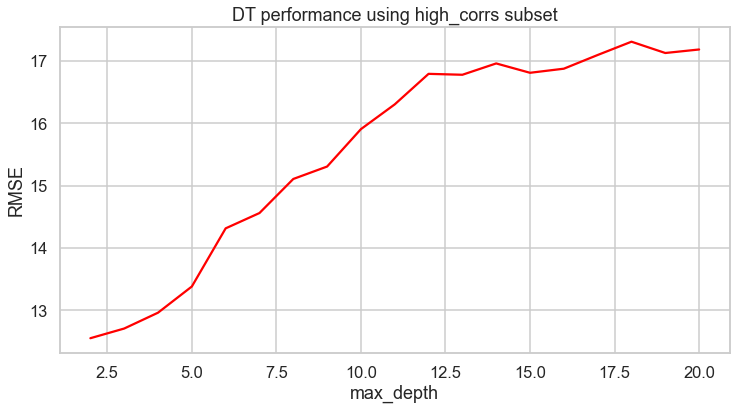

In [313]:
# max_depths from 2-20
d_values = range(2, 21)

# to hold losses
losses = []

for d in d_values:
    dt = DecisionTreeRegressor(random_state=random_state, max_depth=d)
    
    # use best subset found from above
    rmse, r2 = cross_val(dt, df=df, feature_subset=high_corrs, feature_subset_str='high_corrs')
    
    # append losses
    losses.append(rmse) 
    
# plot results
plt.figure(figsize=(12, 6))
sns.lineplot(x=d_values, y=losses, color='red')

plt.title('DT performance using high_corrs subset')
plt.ylabel('RMSE')
plt.xlabel('max_depth');

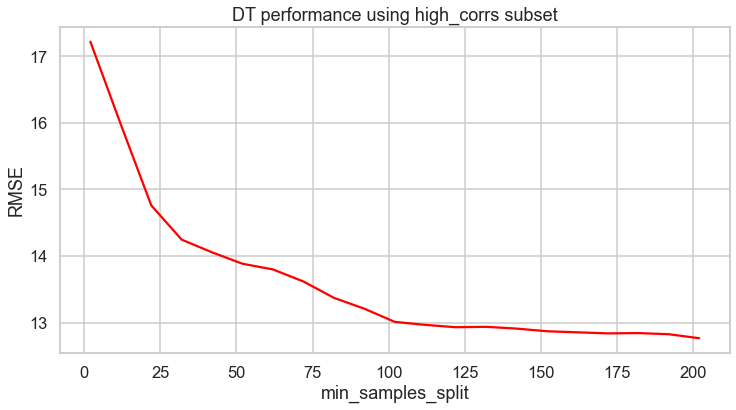

In [314]:
# min_samples_split from 2- 200, increment by 10
s_values = range(2, 203, 10)

# to hold losses
losses = []

for s in s_values:
    dt = DecisionTreeRegressor(random_state=random_state, min_samples_split=s)
    
    # use best subset found from above
    rmse, r2 = cross_val(dt, df=df, feature_subset=high_corrs, feature_subset_str='high_corrs')
    
    # append losses
    losses.append(rmse) 
    
# plot results
plt.figure(figsize=(12, 6))
sns.lineplot(x=s_values, y=losses, color='red')

plt.title('DT performance using high_corrs subset')
plt.ylabel('RMSE')
plt.xlabel('min_samples_split');

In [315]:
# 3 best DTs
models_df[models_df['model'].str.contains('Decision')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
113,12.56,0.28,"DecisionTreeRegressor(max_depth=2, random_stat...",high_corrs,False,False
114,12.71,0.27,"DecisionTreeRegressor(max_depth=3, random_stat...",high_corrs,False,False
152,12.76,0.26,"DecisionTreeRegressor(min_samples_split=202, r...",high_corrs,False,False


### Random Forest

In [316]:
rf = RandomForestRegressor(random_state=random_state)

In [317]:
# normal data
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(rf, df=df, feature_subset=feats, feature_subset_str=name)

In [318]:
models_df[models_df['model'].str.contains('Random')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
153,12.43,0.30,RandomForestRegressor(random_state=9),all_feats,False,False
154,12.44,0.30,RandomForestRegressor(random_state=9),percent_features,False,False
155,12.45,0.30,RandomForestRegressor(random_state=9),high_corrs,False,False


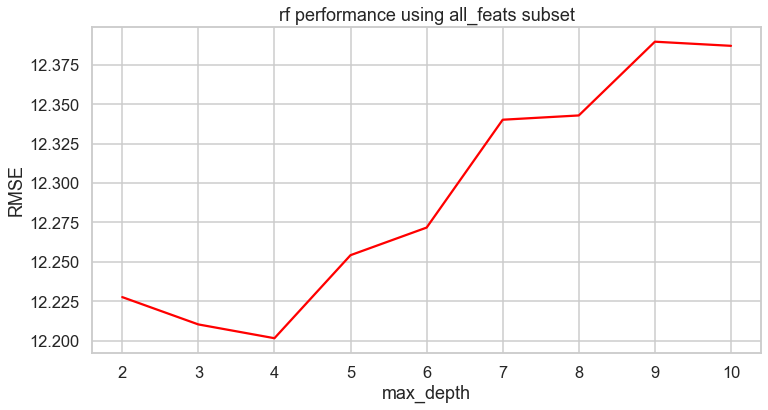

In [319]:
# max_depths from 2-10
d_values = range(2, 11)

# to hold losses
losses = []

for d in d_values:
    rf = RandomForestRegressor(random_state=random_state, max_depth=d)
    
    # use best subset found from above
    rmse, r2 = cross_val(rf, df=df, feature_subset=all_feats, feature_subset_str='all_feats')
    
    # append losses
    losses.append(rmse) 
    
# plot results
plt.figure(figsize=(12, 6))
sns.lineplot(x=d_values, y=losses, color='red')

plt.title('rf performance using all_feats subset')
plt.ylabel('RMSE')
plt.xlabel('max_depth');

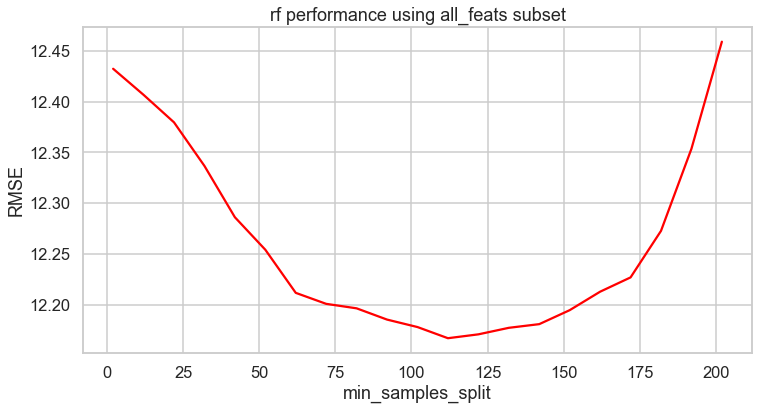

In [320]:
# min_samples_split from 2- 200, increment by 10
s_values = range(2, 203, 10)

# to hold losses
losses = []

for s in s_values:
    rf = RandomForestRegressor(random_state=random_state, min_samples_split=s)
    
    # use best subset found from above
    rmse, r2 = cross_val(rf, df=df, feature_subset=all_feats, feature_subset_str='all_feats')
    
    # append losses
    losses.append(rmse) 
    
# plot results
plt.figure(figsize=(12, 6))
sns.lineplot(x=s_values, y=losses, color='red')

plt.title('rf performance using all_feats subset')
plt.ylabel('RMSE')
plt.xlabel('min_samples_split');

In [321]:
# 3 best RF
models_df[models_df['model'].str.contains('Random')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
180,12.17,0.33,"RandomForestRegressor(min_samples_split=112, r...",all_feats,False,False
181,12.17,0.33,"RandomForestRegressor(min_samples_split=122, r...",all_feats,False,False
182,12.18,0.32,"RandomForestRegressor(min_samples_split=132, r...",all_feats,False,False


- Best RF with a val RMSE of __12.17__. This is now our baseline to beat.

### XGBoost
- XGBosst is notorious for performing well on a wide array of problems.

In [322]:
xgb = XGBRegressor(n_jobs=-1, random_state=random_state, n_estimators=1000, learning_rate=0.01)

In [323]:
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(xgb, df=df, feature_subset=feats, feature_subset_str=name)

In [324]:
# 3 best XGB
models_df[models_df['model'].str.contains('XGB')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
190,12.79,0.26,"XGBRegressor(base_score=None, booster=None, co...",all_feats,False,False
191,13.02,0.23,"XGBRegressor(base_score=None, booster=None, co...",percent_features,False,False
192,13.11,0.22,"XGBRegressor(base_score=None, booster=None, co...",high_corrs,False,False


## Combining models
- After trying 5 different models and searching through many hyperparameters, our best validation results came from the RandomForestRegressor with a val RMSE of __12.17__ and a val R^2 of __0.33__. 
- This is quite poor performance, as the target variable has a mean of 64 and a std of 15. This means that on average, our best preds our almost a full standard deviation off of the true value.
- Next, we will try to combine these models in different ways in an attempt to increase performance.

### VotingRegressor
- Using best model found from each algorithm.

In [325]:
# models that did best with high_corrs subset
lr_best = LinearRegression()
knn_best = KNeighborsRegressor(n_neighbors=46)
dt_best = DecisionTreeRegressor(random_state=random_state, max_depth=2)

# models that did best with all_feats subset
rf_best = RandomForestRegressor(random_state=random_state, min_samples_split=112)
xgb_best = XGBRegressor(random_state=random_state, n_estimators=1000, learning_rate=0.01)

In [326]:
# voting regressor on high_corrs data
vote_1 = VotingRegressor(estimators=[
    ('lr', lr_best), 
    ('knn', knn_best), 
    ('dt', dt_best)])
cross_val(vote_1, df=df, feature_subset=high_corrs, feature_subset_str='high_corrs')

# voting regressor on all_feats data
vote_2 = VotingRegressor(estimators=[
    ('rf', rf_best), 
    ('xgb', xgb_best)])
cross_val(vote_2, df=df, feature_subset=all_feats, feature_subset_str='all_feats')

models_df[models_df['model'].str.contains('Vot')].sort_values('rmse', ascending=True).head()

,rmse,r2,model,feats,pca,poly
197,12.18,0.32,"VotingRegressor(estimators=[('lr', LinearRegre...",high_corrs,False,False
198,12.30,0.31,"VotingRegressor(estimators=[('rf',\n ...",all_feats,False,False


- Results are close, but still not as good as the Random Forest.

### StackingRegressor
- Using best model found from each algorithm.

In [327]:
# stacking regressor on high_corrs data
stack_1 = StackingRegressor(estimators=[
    ('lr', lr_best), 
    ('knn', knn_best), 
    ('dt', dt_best)])
cross_val(stack_1, df=df, feature_subset=high_corrs, feature_subset_str='high_corrs')

# stacking regressor on all_feats data
stack_2 = StackingRegressor(estimators=[
    ('rf', rf_best), 
    ('xgb', xgb_best)])
cross_val(stack_2, df=df, feature_subset=all_feats, feature_subset_str='all_feats')

models_df[models_df['model'].str.contains('Stack')].sort_values('rmse', ascending=True).head()

,rmse,r2,model,feats,pca,poly
200,12.17,0.32,"StackingRegressor(estimators=[('rf',\n ...",all_feats,False,False
199,12.21,0.32,"StackingRegressor(estimators=[('lr', LinearReg...",high_corrs,False,False


- Results are comparable to the random forest, but a StackingRegressor is more complex and computationally intensive than the standalone RF.

In [328]:
# save model results
models_df.to_csv('./models/models.csv')

- After iterating through many different model/feature/hyperparameter combinations, our best model was a __Random Forest with  min_samples_split of 112__. Next, let's make predictions with this optimized model.

# 2023 predictions
- The model will be trained on the entire train/val data, and then will predict 2023 offensive grade from the 2022 holdout set.

In [9]:
# best random forest
rf_best = RandomForestRegressor(random_state=random_state, min_samples_split=112)

# training features and target
X_train = df[all_feats]
y_train = df.target

# 2022 rows are test set
X_test = players_2022[all_feats]
y_test = players_2022.target

# create pieline
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', rf_best)])

# train on entire dataset
pipeline.fit(X_train, y_train)

# predict
preds = pipeline.predict(X_test)

print(f'RMSE: {mean_squared_error(y_test, preds, squared=False)}')
print(f'R^2 : {r2_score(y_test, preds)}')

RMSE: 12.157436114762524
R^2 : 0.397691290884134


- Using the best random forest, we achieved an __RMSE of 12.16__. This means that on average, our 2023 predictions are 12.16 points off the true grade of a player. Our __R^2 is 0.4__, meaning that this model explains 40% of the variation in the target variable.

In [10]:
# create a df for our predictions
preds_df = pd.DataFrame(data={'player': players_2022['player'].values, 'team': players_2022['team_name'].values, 
                              'y_true': y_test, 'y_pred': preds, 'error': (preds - y_test)})

In [ ]:
# map colors to our preds_df
preds_df['color'] = preds_df['team'].map(TEAM_COLORS)

In [12]:
# show 2023 predictions for all 48 QBs
preds_df.sort_values('error')[['player', 'y_true', 'y_pred', 'error']].T

,732,440,282,62,142,987,606,509,1008,976,516,878,433,165,54,542,579,540,863,831,781,334,425,920,1017,133,558,877,397,385,545,329,601,481,478,273,335,116,616,291,617,748,991,91,57,775,754,22
player,Matthew Stafford,Jared Goff,Dak Prescott,Baker Mayfield,Brock Purdy,Tua Tagovailoa,Lamar Jackson,Jordan Love,Tyrod Taylor,Trevor Lawrence,Josh Allen,Sam Howell,Jameis Winston,C.J. Beathard,Andy Dalton,Justin Fields,Kirk Cousins,Joshua Dobbs,Ryan Tannehill,Russell Wilson,Patrick Mahomes,Deshaun Watson,Jalen Hurts,Taylor Heinicke,Zach Wilson,Brian Hoyer,Kenny Pickett,Sam Darnold,Geno Smith,Gardner Minshew,Justin Herbert,Derek Carr,Kyler Murray,Joe Burrow,Jimmy Garoppolo,Cooper Rush,Desmond Ridder,Brett Rypien,Mac Jones,Daniel Jones,Malik Willis,Mike White,Tyler Huntley,Blaine Gabbert,Bailey Zappe,P.J. Walker,Mitch Trubisky,Aaron Rodgers
y_true,83.70,90.60,87.60,73.30,78.10,87.50,87.50,71.30,66.80,82.70,89.80,67.50,67.70,66.20,81.10,73.60,86.10,66.30,72.00,77.10,87.10,66.90,81.30,65.30,59.90,57.90,66.80,59.80,75.30,56.60,77.80,68.10,65.60,78.00,65.60,53.10,48.90,48.10,59.00,63.00,45.90,46.20,45.20,40.20,41.30,30.80,34.80,39.40
y_pred,61.97,72.23,72.68,59.95,65.90,75.70,75.84,60.18,57.16,73.49,80.73,59.27,59.76,58.36,74.31,66.85,79.54,59.97,65.76,71.09,81.66,61.52,77.64,62.26,56.90,54.99,63.92,58.49,74.60,57.99,79.60,71.37,69.12,81.61,70.24,58.31,55.38,56.39,68.35,73.04,58.70,59.49,60.60,56.92,60.91,55.95,62.58,78.00
error,-21.73,-18.37,-14.92,-13.35,-12.20,-11.80,-11.66,-11.12,-9.64,-9.21,-9.07,-8.23,-7.94,-7.84,-6.79,-6.75,-6.56,-6.33,-6.24,-6.01,-5.44,-5.38,-3.66,-3.04,-3.00,-2.91,-2.88,-1.31,-0.70,1.39,1.80,3.27,3.52,3.61,4.64,5.21,6.48,8.29,9.35,10.04,12.80,13.29,15.40,16.72,19.61,25.15,27.78,38.60


In [13]:
# percent of preds within 10 pts
percent = (preds_df.error.abs() < 10).sum() / len(preds_df)

print(f'{percent*100:.1f}% of our model\'s predictions are within 10 pts of the true value.')

64.6% of our model's predictions are within 10 pts of the true value.


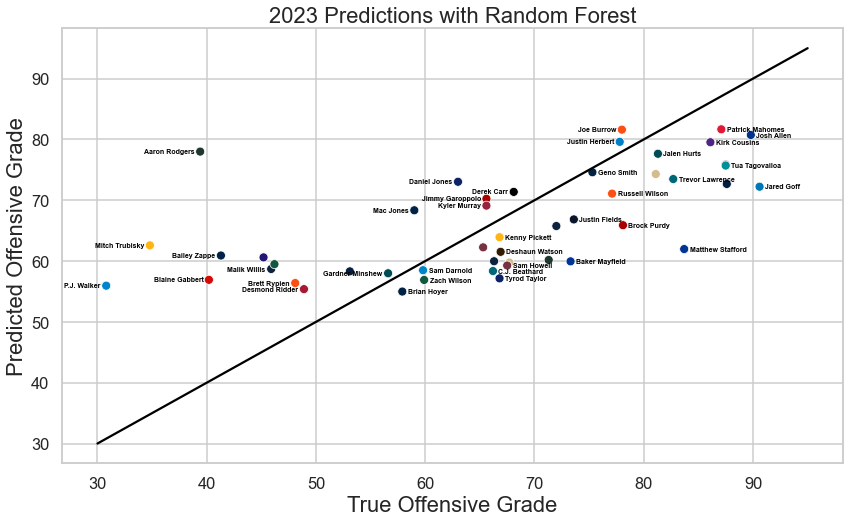

In [19]:
# visualize 2023 predictions
plt.figure(figsize=(14, 8))

# lists for annotating player names
over_drops = ['Mike White', 'Cooper Rush', 'Tyler Huntley']
under_drops = ['Jameis Winston', 'Taylor Heinicke', 'Ryan Tannehill', 'Andy Dalton', 'Dak Prescott', 'Joshua Dobbs', 
               'Lamar Jackson', 'Jordan Love']

# title, labels
plt.title('2023 Predictions with Random Forest', fontsize=22)
plt.xlabel('True Offensive Grade', fontsize=22)
plt.ylabel('Predicted Offensive Grade', fontsize=22)

# team colors
color_palette = {color: color for color in preds_df['color'].unique()}

# plot players as points
sns.scatterplot(data=preds_df, x='y_true', y='y_pred', hue='color', palette=color_palette, legend=False)

# plot line to show perfect predictions
sns.lineplot(x=range(30,96), y=range(30,96), color='black')

# annotating each point with the player's name
for index, row in preds_df.iterrows():
    # over preds (above line)
    if (row['y_pred'] > row['y_true']) and (row['player'] not in over_drops):
        plt.text(row['y_true']-0.5, row['y_pred']-0.3, row['player'], horizontalalignment='right', color='black', 
             weight='semibold', fontsize=7)
    # under preds (below line)
    elif (row['y_pred'] < row['y_true']) and (row['player'] not in under_drops):
        plt.text(row['y_true']+0.5, row['y_pred']-0.3, row['player'], horizontalalignment='left', color='black', 
             weight='semibold', fontsize=7)
             
plt.savefig('./images/preds_1');

- Each point represents a single player in 2023. The distance from the black line is how far off our prediction was. Ideally, a perfect model would only have dots on the line. 
- Dots above the line are cases in which our model __overpredicted__ the player's performance, and dots below the line are __underpredictions__.
- You can see that the worst prediction, by far, is __Aaron Rodgers__, with an error of 38.6. It should be noted that he was injured on the 4th play of the 2023 season with a torn achilles, so this point is definitely an outlier.

In [17]:
# all 48 QBs
print(f'Normal - RMSE: {mean_squared_error(y_test, preds, squared=False)}')
print(f'Normal - R^2 : {r2_score(y_test, preds)}\n')

# dropping aaron rodgers
print(f'Dropping Aaron Rodgers - RMSE: {mean_squared_error(y_test[1:], preds[1:], squared=False)}')
print(f'Dropping Aaron Rodgers - R^2 : {r2_score(y_test[1:], preds[1:])}')

Normal - RMSE: 12.157436114762524
Normal - R^2 : 0.397691290884134

Dropping Aaron Rodgers - RMSE: 10.920073785075424
Dropping Aaron Rodgers - R^2 : 0.492223269173908


- If we drop this point, our RMSE goes from a __12.16 to a 10.92__, and R^2 leaps from a __0.4 to a 0.49__.

In [18]:
# percent of preds within 10 pts
percent = (preds_df[1:].error.abs() < 10).sum() / (len(preds_df) - 1)

print(f'Excluding Aaron Rodgers, {percent*100:.1f}% of our model\'s predictions are within 10 pts of the true value.')

Excluding Aaron Rodgers, 66.0% of our model's predictions are within 10 pts of the true value.


# Conclusion
- Using an optimized __RandomForestRegressor__, we were able to predict 2023 QB offensive grade with an __RMSE of 10.92__ and an __R^2 of 0.49__.
- It should also be noted that these accuracy metrics are only taken from the __first 10 weeks of the 2023 season__. This repository will be updated once the 2023 season is complete; I will show the error and R^2 of the best model on the full 2023 season. 
- Stay tuned for predictions on the 2024 NFL season!